
...............................................

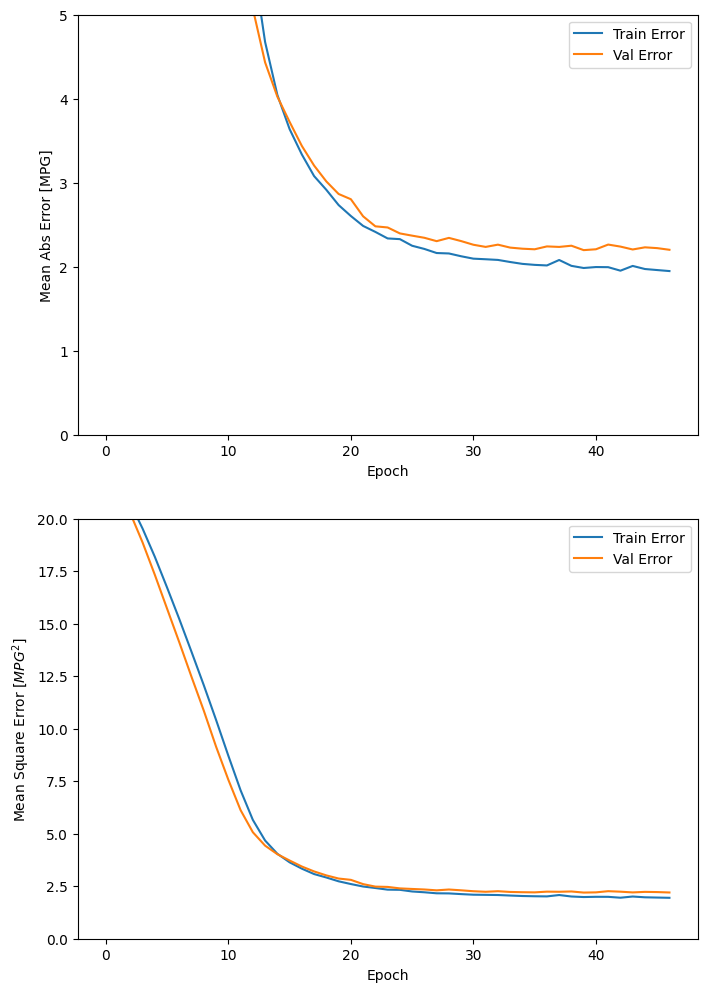

3/3 - 0s - loss: 6.3178 - mae: 1.9893 - mse: 6.3178 - 28ms/epoch - 9ms/step


테스트 셋의 평균 절대 오차:  1.99 MPG
3/3 [==============================] - 0s 4ms/step


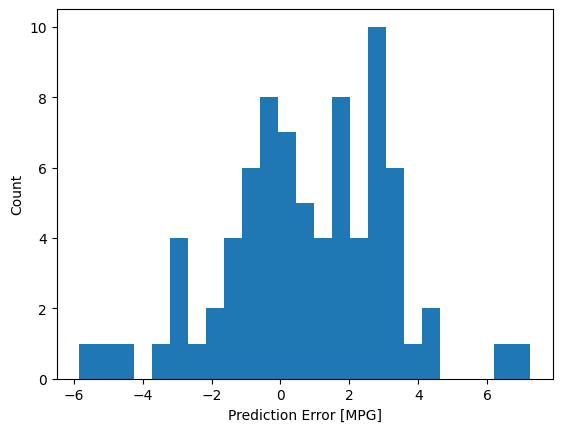

In [26]:
# 회귀(자동차 연비 예측) : 가격이나 확률 같은 연속된 출력 값을 예측
import os
import sys
from google.colab import drive

# 드라이브 마운트 및 패키지 경로 작업
# drive.mount("/content/drive", force_remount=True)
# my_path = "/content/package"
# save_path = "/content/drive/MyDrive/Colab Notebooks/package"

# os.symlink(save_path, my_path)
# sys.path.insert(0, my_path)

# 산점도 행렬(Scatterplot Matrix)을 그리기 위한 seaborn 패키지 설치
# !pip install --target=$my_path -q seaborn

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Auto MPG 데이터셋 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
# dataset_path

# pandas를 사용해 데이터 읽기
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
# dataset.tail()

# 데이터 정제
# dataset.isna().sum()
dataset = dataset.dropna()                      # 누락된 행 삭제

origin = dataset.pop("Origin")                  # "Origin"열은 수치형이 아닌 범주형이므로 one-hot 인코딩으로 변환
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0
dataset.tail()

# 데이터셋을 훈련 셋과 테스트 셋으로 분할
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 데이터 조사
# sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
# train_stats

# 특성과 레이블 분리
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

# 데이터 정규화
# 특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됨.
# 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련이 어렵고 입력 단위에 의존적인 모델이 생성됨.
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 모델
## 모델 구성
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.RMSprop(0.001),
                  metrics=["mae", "mse"])
    return model

# model = build_model()

## 모델 확인
# model.summary()

# example_batch = normed_train_data[:10]
# example_result = model.predict(example_batch)
# example_result

## 모델 훈련
# epoch가 끝날 때마다 점을 출력해 훈련 진행 과정 표시
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

# history = model.fit(normed_train_data, train_labels,
#                     epochs=EPOCHS, validation_split=0.2, verbose=0,
#                     callbacks=[PrintDot()])                          # 점 찍기 콜백 함수

# hist = pd.DataFrame(history.history)
# hist["epoch"] = history.epoch
# hist.tail()

## 모델 훈련 과정 시각화
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure(figsize=(8, 12))
    plt.subplot(2, 1, 1)
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist["epoch"], hist["mae"],
             label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"],
             label="Val Error")
    plt.ylim([0, 5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist["epoch"], hist["mae"],
             label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"],
             label="Val Error")
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

# plot_history(history)

## 모델 개선 (검증 점수가 향상되지 않으면 자동 훈련 종료)
model = build_model()

# patience 매개변수는 성능 향상을 체크할 epoch 횟수
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

## 모델 평가
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 셋의 평균 절대 오차: {:5.2f} MPG".format(mae))

# 예측
test_predictions = model.predict(normed_test_data).flatten()

# plt.scatter(test_labels, test_predictions)
# plt.xlabel("True Values [MPG]")
# plt.ylabel("Predictions [MPG]")
# plt.axis("equal")
# plt.axis("square")
# plt.xlim([0, plt.xlim()[1]])
# plt.ylim([0, plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")